In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kstest, gennorm
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [51]:
wti = yf.download('CL=F', start='2000-01-01', end='2023-12-31')
wti['Date'] = pd.to_datetime(wti.index)
wti['Year'] = wti['Date'].dt.year
wti = wti.set_index('Date')   
wti['Daily_Return'] = wti['Adj Close'].pct_change()
wti['Log_Return'] = np.log(wti['Adj Close']).diff()

[*********************100%%**********************]  1 of 1 completed


In [52]:
wti.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Year,Daily_Return,Log_Return
Date,,,,,,,,,
2023-12-15,71.610001,72.220001,70.300003,71.430000,71.430000,95513,2023,-0.002096,-0.002098
2023-12-18,71.680000,74.260002,70.639999,72.470001,72.470001,73941,2023,0.014560,0.014455
2023-12-19,72.480003,74.010002,71.849998,73.440002,73.440002,230042,2023,0.013385,0.013296
2023-12-20,74.059998,75.370003,73.599998,74.220001,74.220001,273364,2023,0.010621,0.010565
2023-12-21,73.809998,74.580002,72.440002,73.889999,73.889999,251982,2023,-0.004446,-0.004456
2023-12-22,73.910004,74.980003,73.389999,73.559998,73.559998,222600,2023,-0.004466,-0.004476
2023-12-26,73.559998,76.180000,73.129997,75.570000,75.570000,208715,2023,0.027325,0.026958
2023-12-27,75.320000,75.660004,73.769997,74.110001,74.110001,253323,2023,-0.019320,-0.019509
2023-12-28,73.800003,74.400002,71.720001,71.769997,71.769997,262748,2023,-0.031575,-0.032084


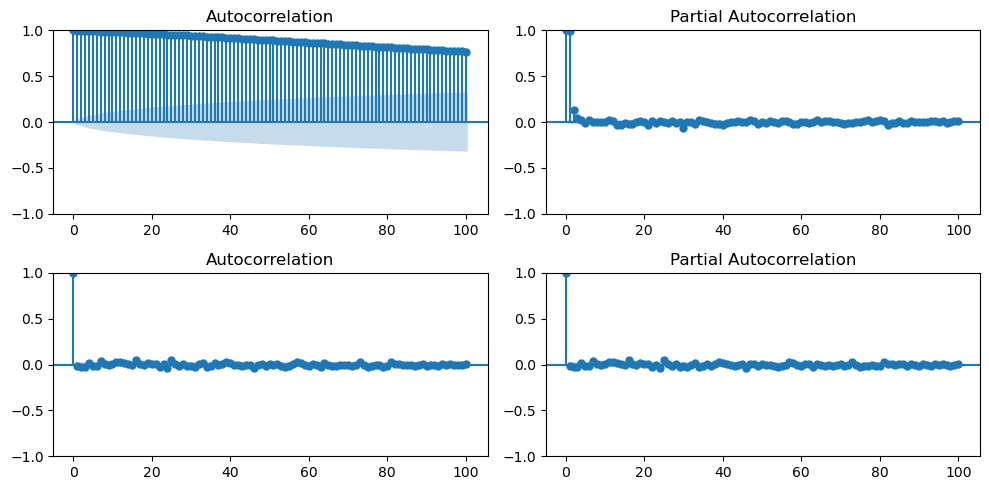

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
plot_acf(wti['Close'].dropna(), ax=axs[0,0], lags=100)
plot_pacf(wti['Close'].dropna(), ax=axs[0,1], lags=100)
plot_acf(wti['Log_Return'].dropna(), ax=axs[1,0], lags=100)
plot_pacf(wti['Log_Return'].dropna(), ax=axs[1,1], lags=100)
plt.tight_layout(); plt.show()

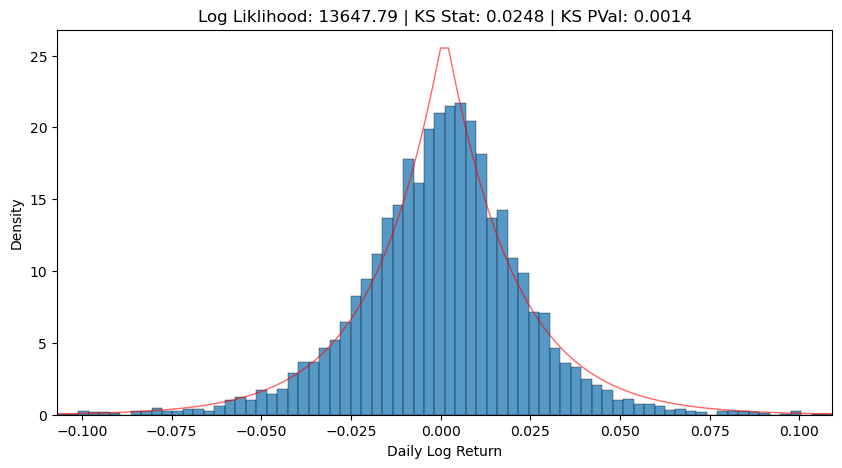

In [54]:
params = gennorm.fit(wti['Log_Return'].dropna())
log_likelihood = gennorm.logpdf(wti['Log_Return'].dropna(), *params).sum()
ks_stat, ks_stat_pval = kstest(wti['Log_Return'].dropna(), 'gennorm', params)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(wti['Log_Return'].dropna(), kde=False, stat='density', ax=ax)
x = np.linspace(gennorm.ppf(0.001, params[0], params[1], params[2]), 
                    gennorm.ppf(0.999, params[0], params[1], params[2]), 
                    100)
ax.plot(x, gennorm.pdf(x, params[0], params[1], params[2]), 'r-', 
                lw=1, alpha=0.6, label='GED fit')
ax.set(title=f'Log Liklihood: {log_likelihood:.2f} | KS Stat: {ks_stat:.4f} | KS PVal: {ks_stat_pval:.4f}',
       xlabel='Daily Log Return', ylabel='Density', xlim=(np.min(x), np.max(x)))
plt.show()  

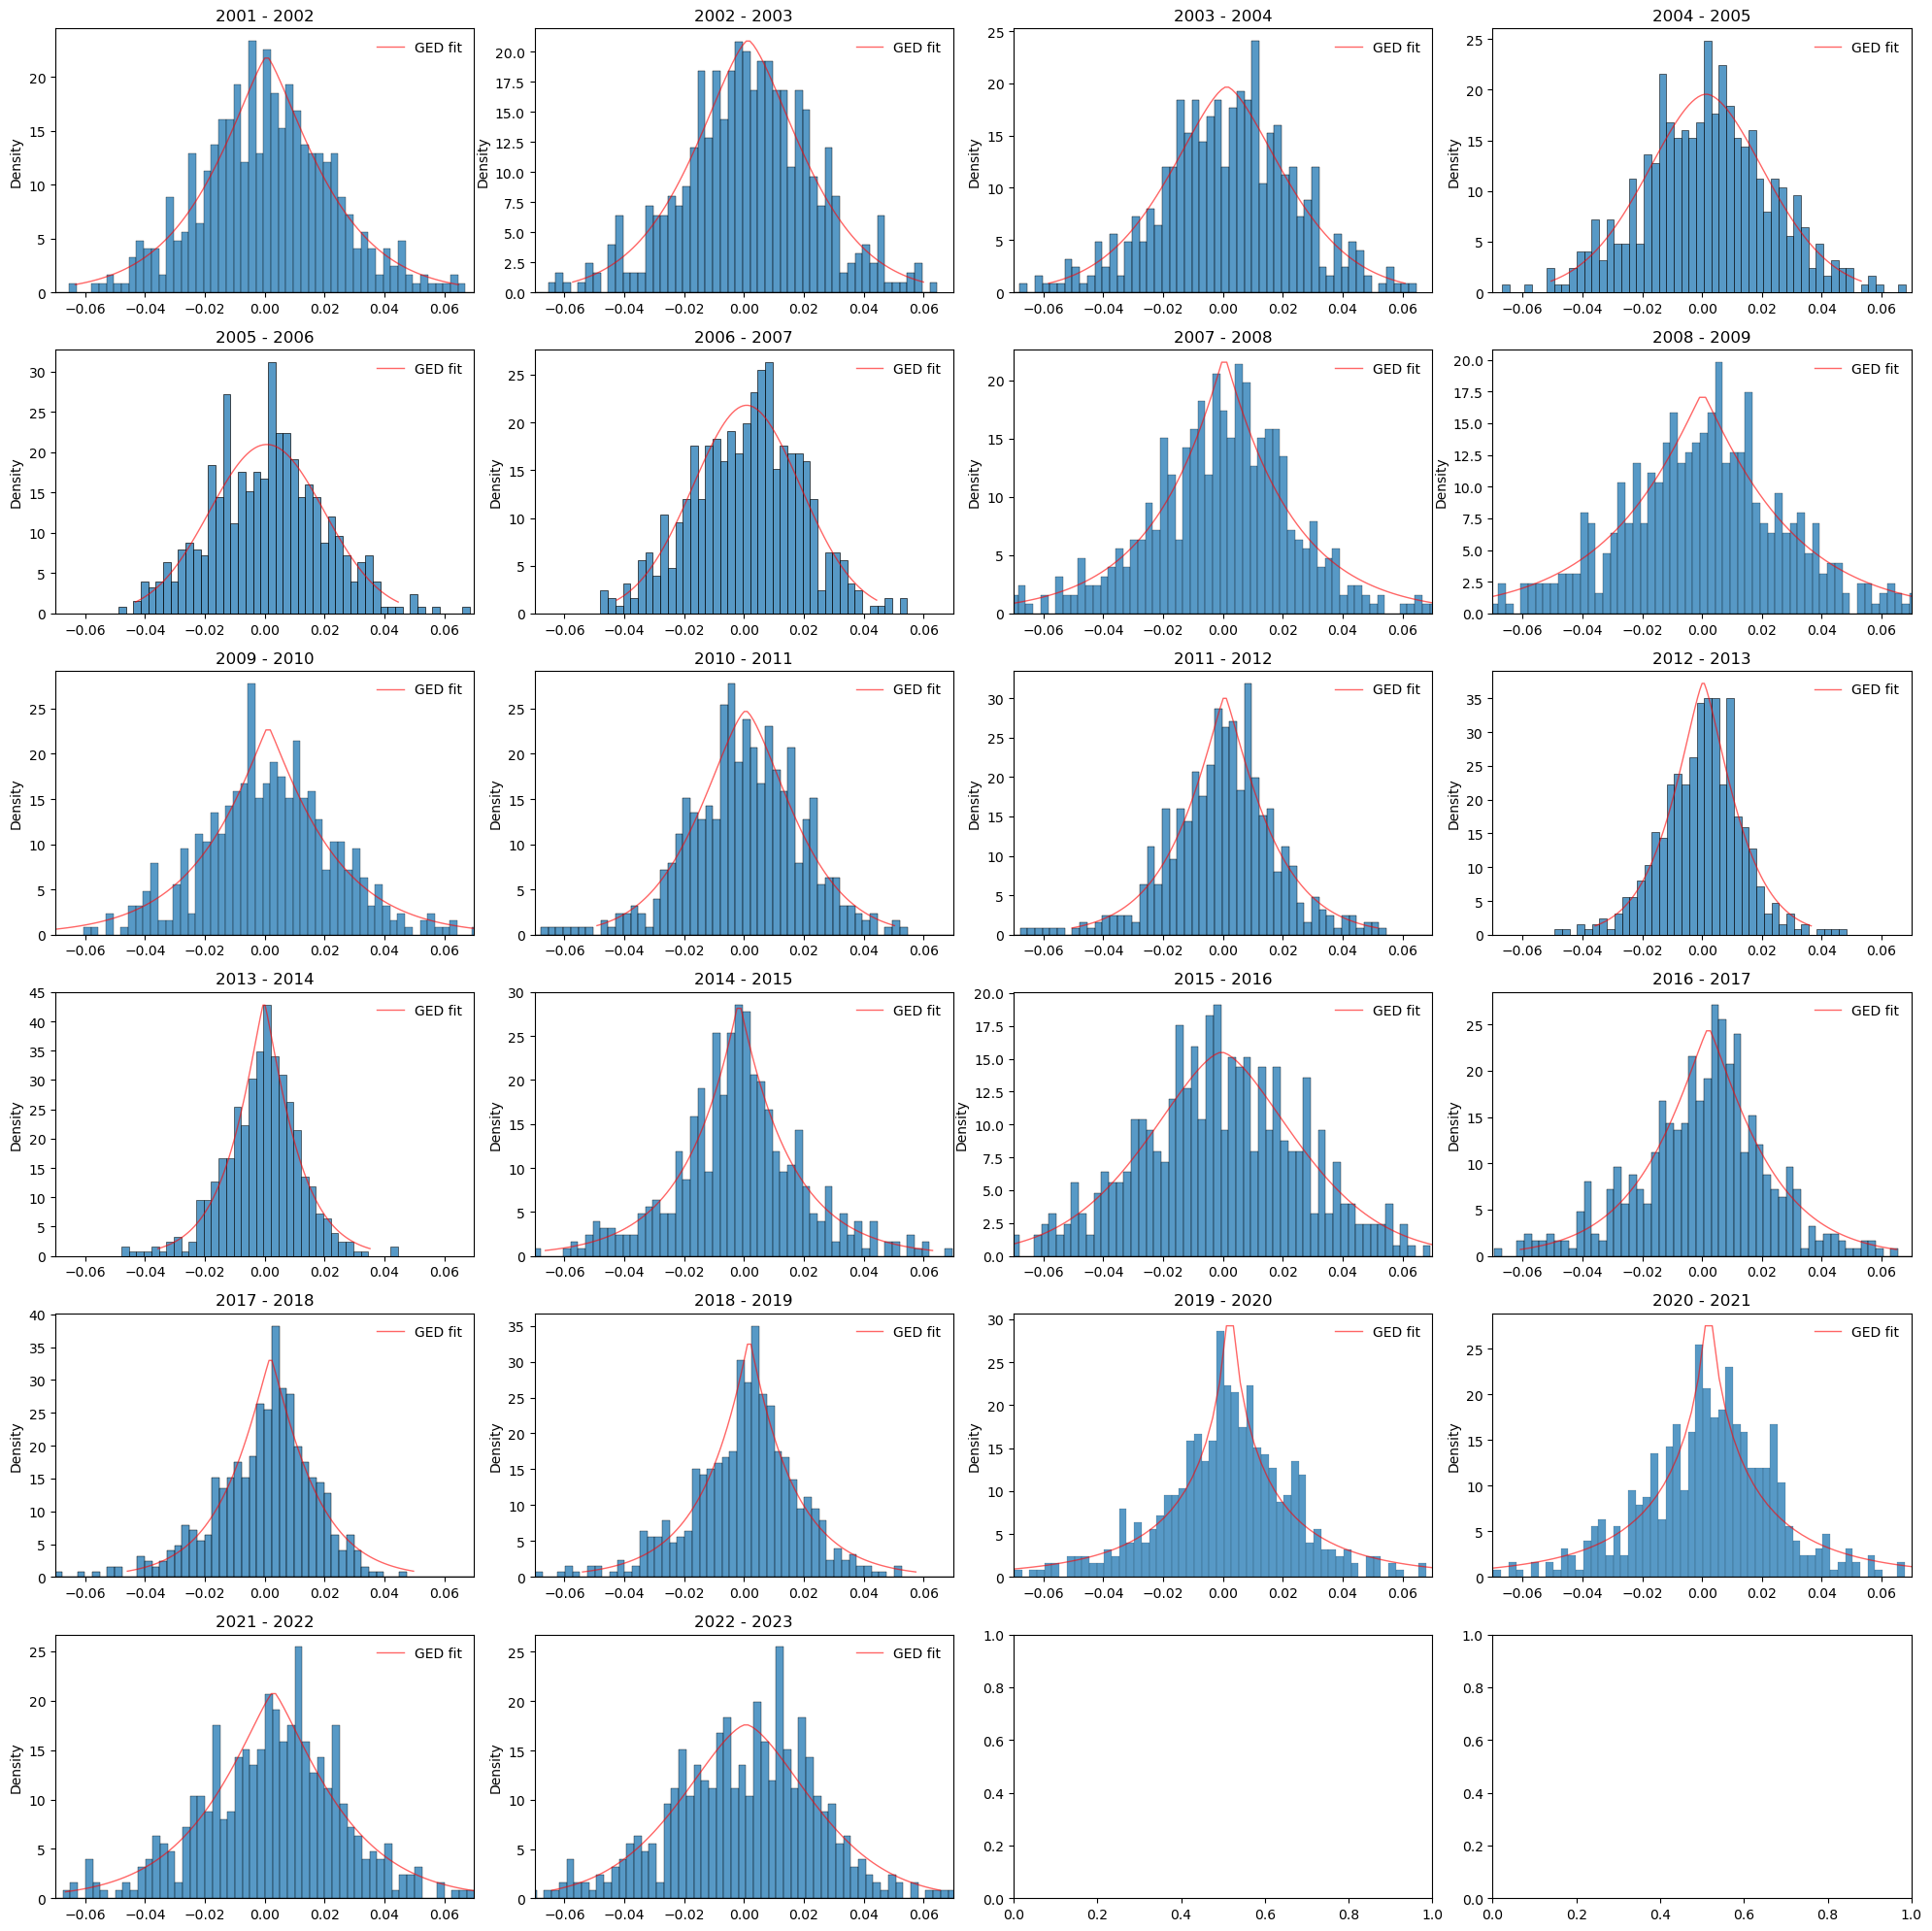

In [123]:
years = wti['Year'].unique()
window_size_years = 2
distributions = pd.DataFrame(index=years, columns=['Beta', 'Loc', 'Scale', 
                                                   'Median', 'Mean', 'Std',
                                                   'Log_Likelihood', 'KS_Stat', 'KS_Pval']) 
fig, axs = plt.subplots(nrows=(len(years)+1)//4, ncols=4, figsize=(20, 20))
for i, y in enumerate(years[window_size_years:]):
    ax = axs[i//4, i%4]
    label = f'{y - window_size_years + 1} - {y}'
    data = wti.loc[(wti['Year'] > y - window_size_years) & (wti['Year'] < y + 1), 'Log_Return']
    data = np.where((data == np.inf) | (data == -np.inf), np.nan, data)
    data = data[~np.isnan(data)]
    params = gennorm.fit(data)
    log_likelihood = gennorm.logpdf(data, beta=params[0], loc=params[1], scale=params[2]).sum()
    ks_stat, ks_stat_pval = kstest(data, 'gennorm', args=(params[0], params[1], params[2]))
    distributions.loc[y] = [params[0], params[1], params[2],
                            np.median(data), np.mean(data), np.std(data),
                            log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=ax, stat='density', binwidth=0.0025)
    x = np.linspace(gennorm.ppf(0.01, params[0], params[1], params[2]), 
                    gennorm.ppf(0.99, params[0], params[1], params[2]), 
                    100)
    ax.plot(x, gennorm.pdf(x, params[0], params[1], params[2]), 'r-', 
                lw=1, alpha=0.6, label='GED fit')
    ax.set(title=label, xlim=(-0.07, 0.07))  
    ax.legend(loc='best', frameon=False)
plt.tight_layout(); plt.show()
    
    

In [124]:
distributions

,Beta,Loc,Scale,Median,Mean,Std,Log_Likelihood,KS_Stat,KS_Pval
2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,1.284487,0.000634,0.024593,0.000709,0.000306,0.024959,1148.393123,0.02353,0.939904
2003,1.451671,0.001395,0.026301,0.001427,0.000988,0.02333,1177.104925,0.026759,0.8568
2004,1.521679,0.001276,0.02818,0.00222,0.000664,0.023985,1159.095527,0.032235,0.665292
2005,1.787683,0.001334,0.028733,0.001909,0.001259,0.021671,1207.088328,0.019523,0.98927
2006,2.025684,0.000679,0.026944,0.00165,0.000679,0.018928,1276.642692,0.031866,0.676818
2007,1.949066,0.000927,0.025874,0.002084,0.000902,0.018547,1289.416217,0.028509,0.798174
2008,1.03966,0.000418,0.022828,0.000419,-0.000622,0.030907,1080.898797,0.036276,0.507986
2009,1.091238,0.000161,0.029593,0.000272,-0.000377,0.03676,981.595739,0.022953,0.947321


In [125]:
simulations = pd.DataFrame(index=years, columns=['Sim_Pct_Return', 'Sum_Cum_Return', 'Sim_Prices'])
for y in years[window_size_years+1:]:
    last_price = wti.loc[(wti['Year'] == y-1), 'Close'].iloc[-1]
    log_return = gennorm.rvs(beta=distributions.loc[y-1, 'Beta'], 
                             loc=distributions.loc[y-1, 'Loc'],
                             scale=distributions.loc[y-1, 'Scale'],
                             size=(wti.loc[(wti['Year'] == y), 'Close'].shape[0], 100)) 
    cum_return = np.cumsum(log_return, axis=0)
    sim_prices = last_price * np.exp(cum_return)
    simulations.loc[y] = [log_return, cum_return, sim_prices]
    pass
    

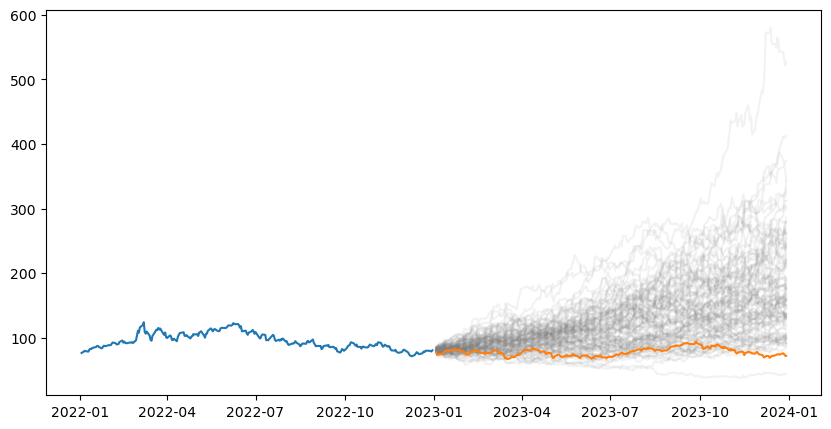

In [126]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(wti.loc[(wti['Year'] == 2022), 'Close'], label='Prior Year')
for i in range(100):
    ax.plot(wti.loc[(wti['Year'] == 2023), 'Close'].index, sim_prices[:, i], '-', c='gray', alpha=0.1)
ax.plot(wti.loc[(wti['Year'] == 2023), 'Close'], label='Actual')
plt.show()

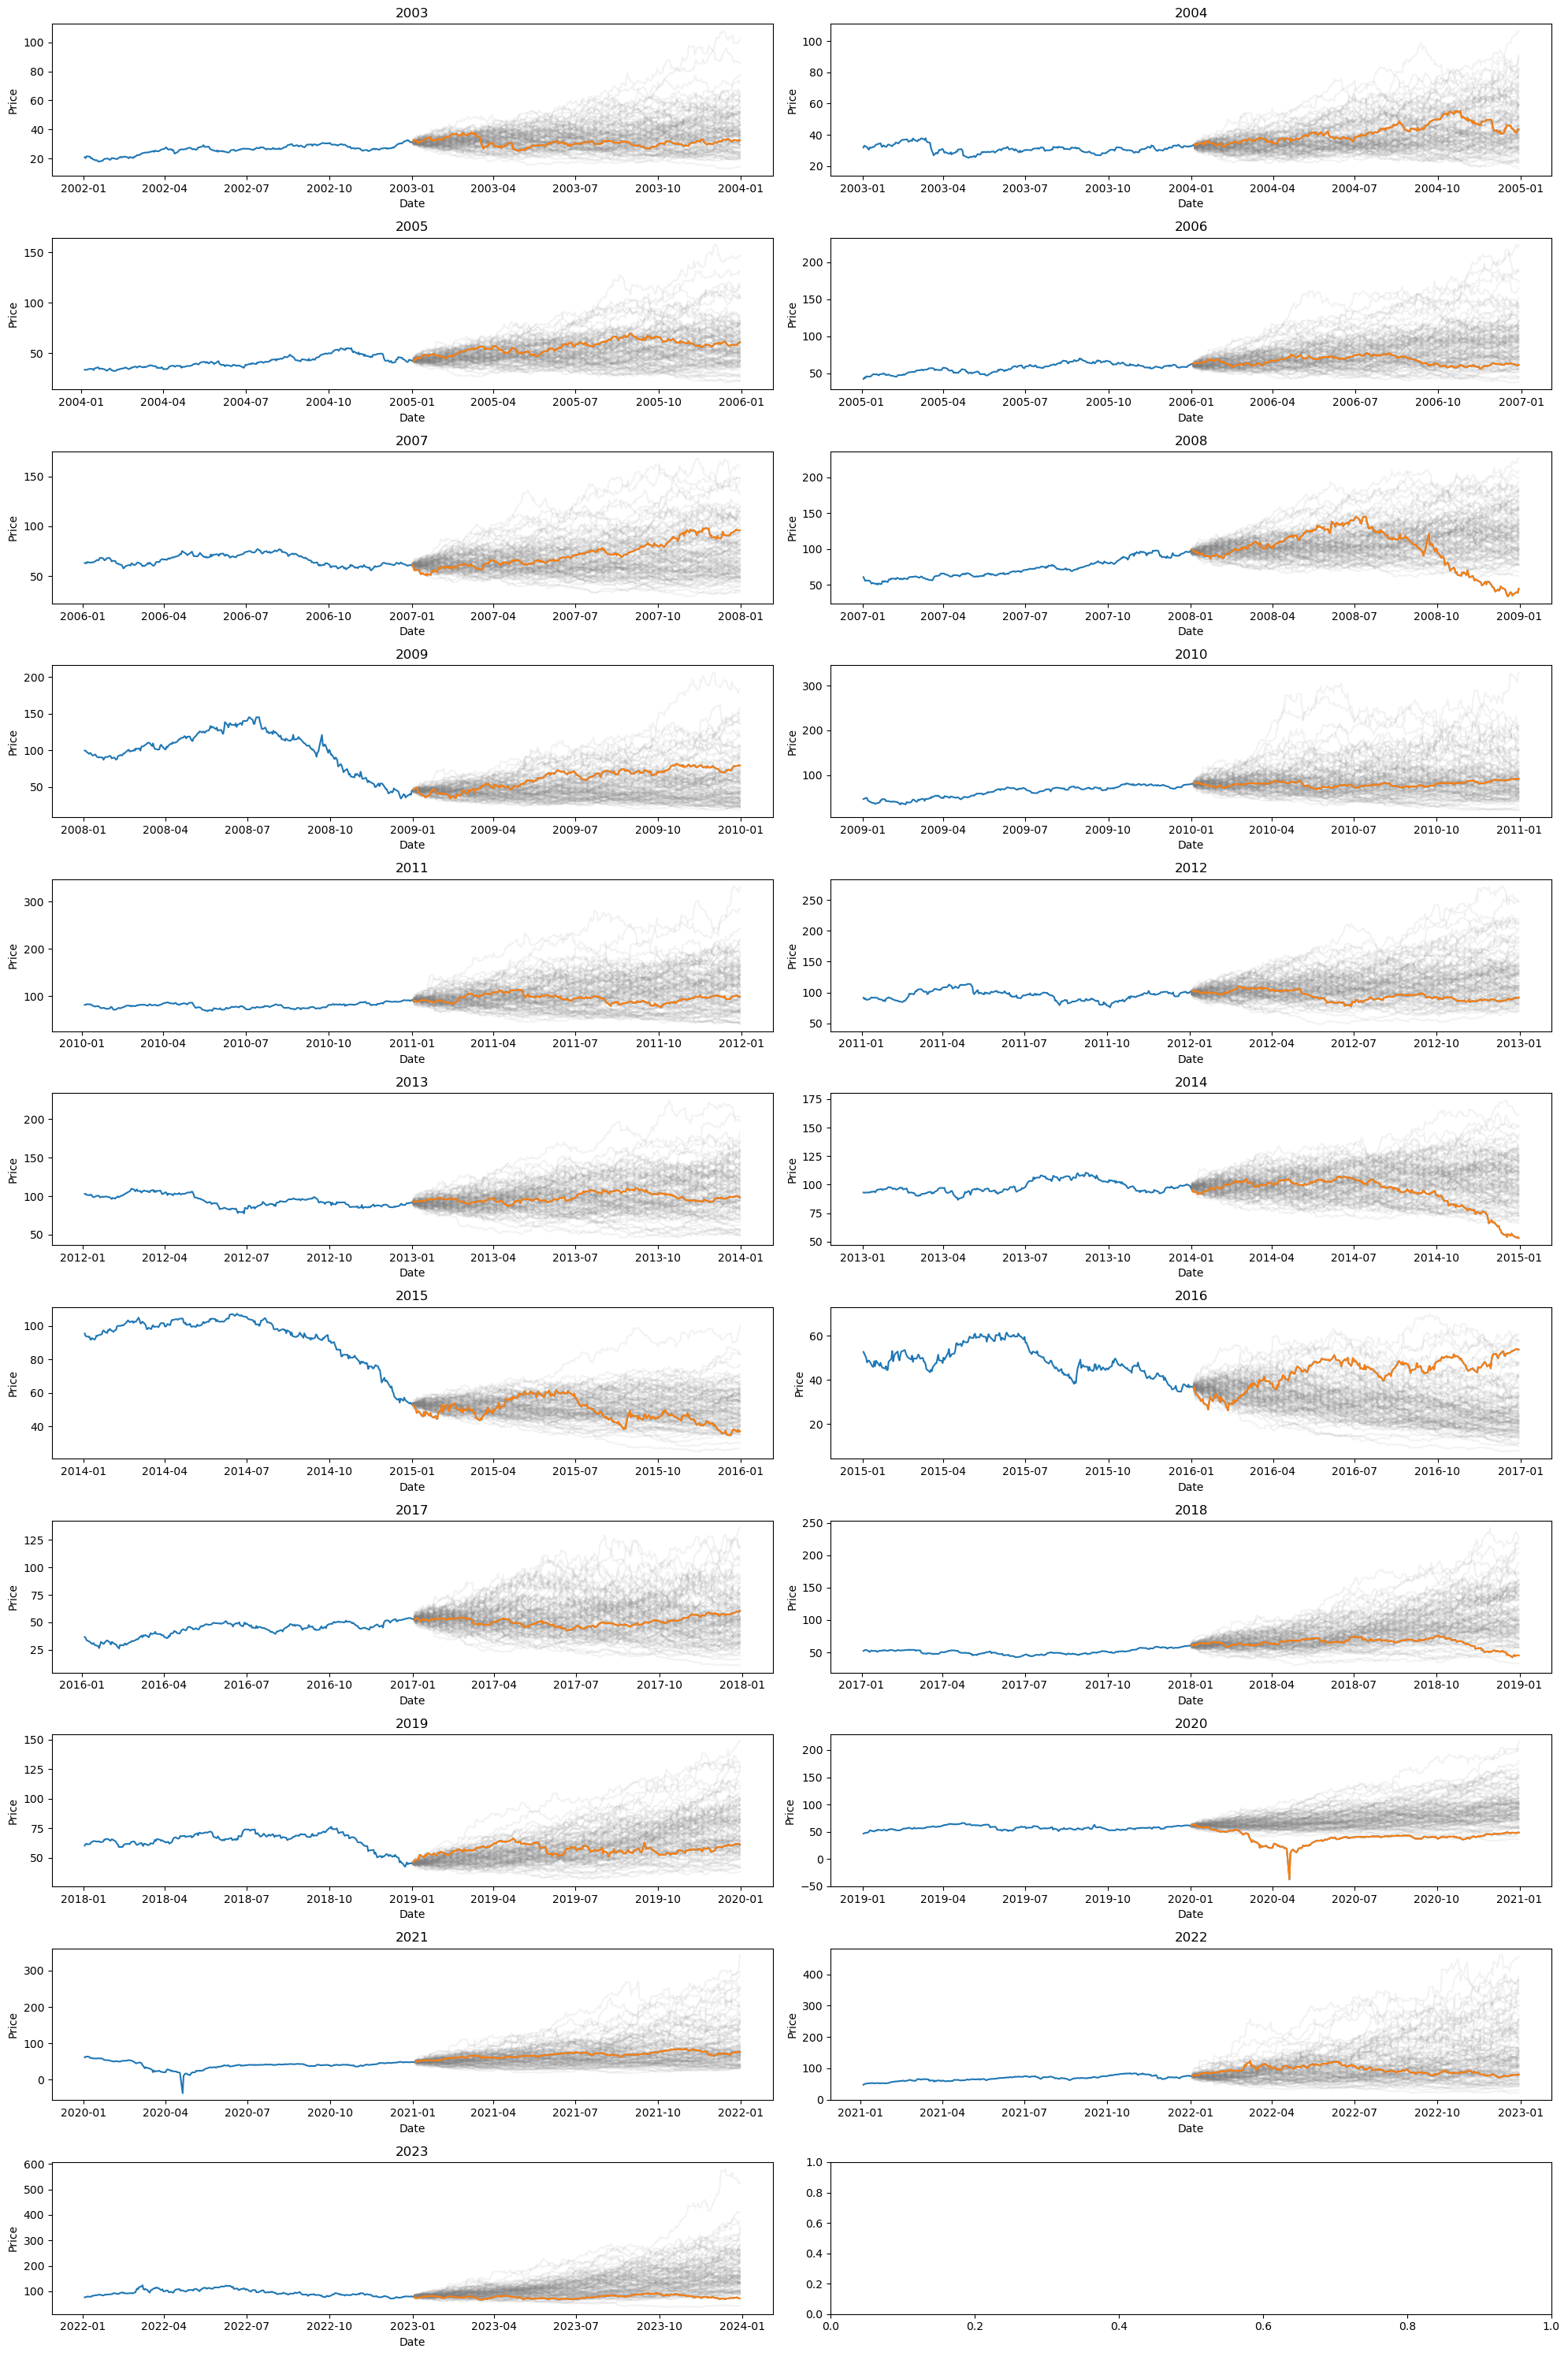

In [129]:
fig, axs = plt.subplots(nrows=(len(years[window_size_years:]))//2, ncols=2, figsize=(20, 30))
for i, y in enumerate(years[window_size_years+1:]):
    ax = axs[i//2, i%2]
    ax.plot(wti.loc[(wti['Year'] > y - window_size_years) & (wti['Year'] < y + 1), 'Close'], label='Prior Year')
    for i in range(100):
        ax.plot(wti.loc[(wti['Year'] == y), 'Close'].index, simulations.loc[y, 'Sim_Prices'][:, i], '-', c='gray', alpha=0.1)
    ax.plot(wti.loc[(wti['Year'] == y), 'Close'], label='Actual')
    ax.set(title=y, xlabel='Date', ylabel='Price')
plt.tight_layout(); plt.show()

In [130]:
confidence_intervals = [10, 20, 30, 40, 50, 60, 70, 80, 90]
ci_scores = pd.DataFrame(index=years, columns=confidence_intervals)
for y in years[window_size_years+1:]:
    actual = wti.loc[(wti['Year'] == y), 'Close']
    trading_days = actual.shape[0]
    sim_prices = simulations.loc[y, 'Sim_Prices']
    scores = []
    for ci in confidence_intervals:
        lower_bound = np.percentile(sim_prices, 50 - (ci / 2), axis=1)
        upper_bound = np.percentile(sim_prices, 50 + (ci / 2), axis=1)
        score = np.logical_and(lower_bound < actual, actual < upper_bound).sum() / trading_days
        scores.append(score)
    ci_scores.loc[y] = scores

scores = []
for row in ci_scores.dropna().iterrows():
    ci_intervals = row[1].index / 100   
    indicator = (row[1].values >= ci_intervals).astype(int)
    goodness = 1 - (3 * indicator - 2) * (row[1].values - ci_intervals)
    piecewise = np.trapz(y=goodness, x=ci_intervals)
    scores.append(piecewise)

In [131]:
ci_scores.loc[years[window_size_years+1:], :]

,10,20,30,40,50,60,70,80,90
2003,0.016,0.096,0.256,0.472,0.712,0.808,0.904,0.984,1.0
2004,0.124498,0.24498,0.405622,0.64257,0.883534,0.967871,0.987952,0.991968,1.0
2005,0.12749,0.298805,0.422311,0.553785,0.697211,0.864542,0.940239,0.988048,1.0
2006,0.264,0.428,0.52,0.584,0.656,0.704,0.792,0.992,1.0
2007,0.154762,0.289683,0.456349,0.579365,0.722222,0.873016,0.928571,0.928571,0.948413
2008,0.071146,0.146245,0.209486,0.26087,0.347826,0.442688,0.541502,0.699605,0.778656
2009,0.02381,0.055556,0.119048,0.166667,0.269841,0.531746,0.833333,0.964286,0.97619
2010,0.40873,0.722222,0.90873,0.944444,0.980159,0.996032,1.0,1.0,1.0
2011,0.146825,0.297619,0.496032,0.722222,0.920635,0.984127,0.992063,1.0,1.0
2012,0.112,0.204,0.288,0.34,0.432,0.58,0.828,0.968,0.996


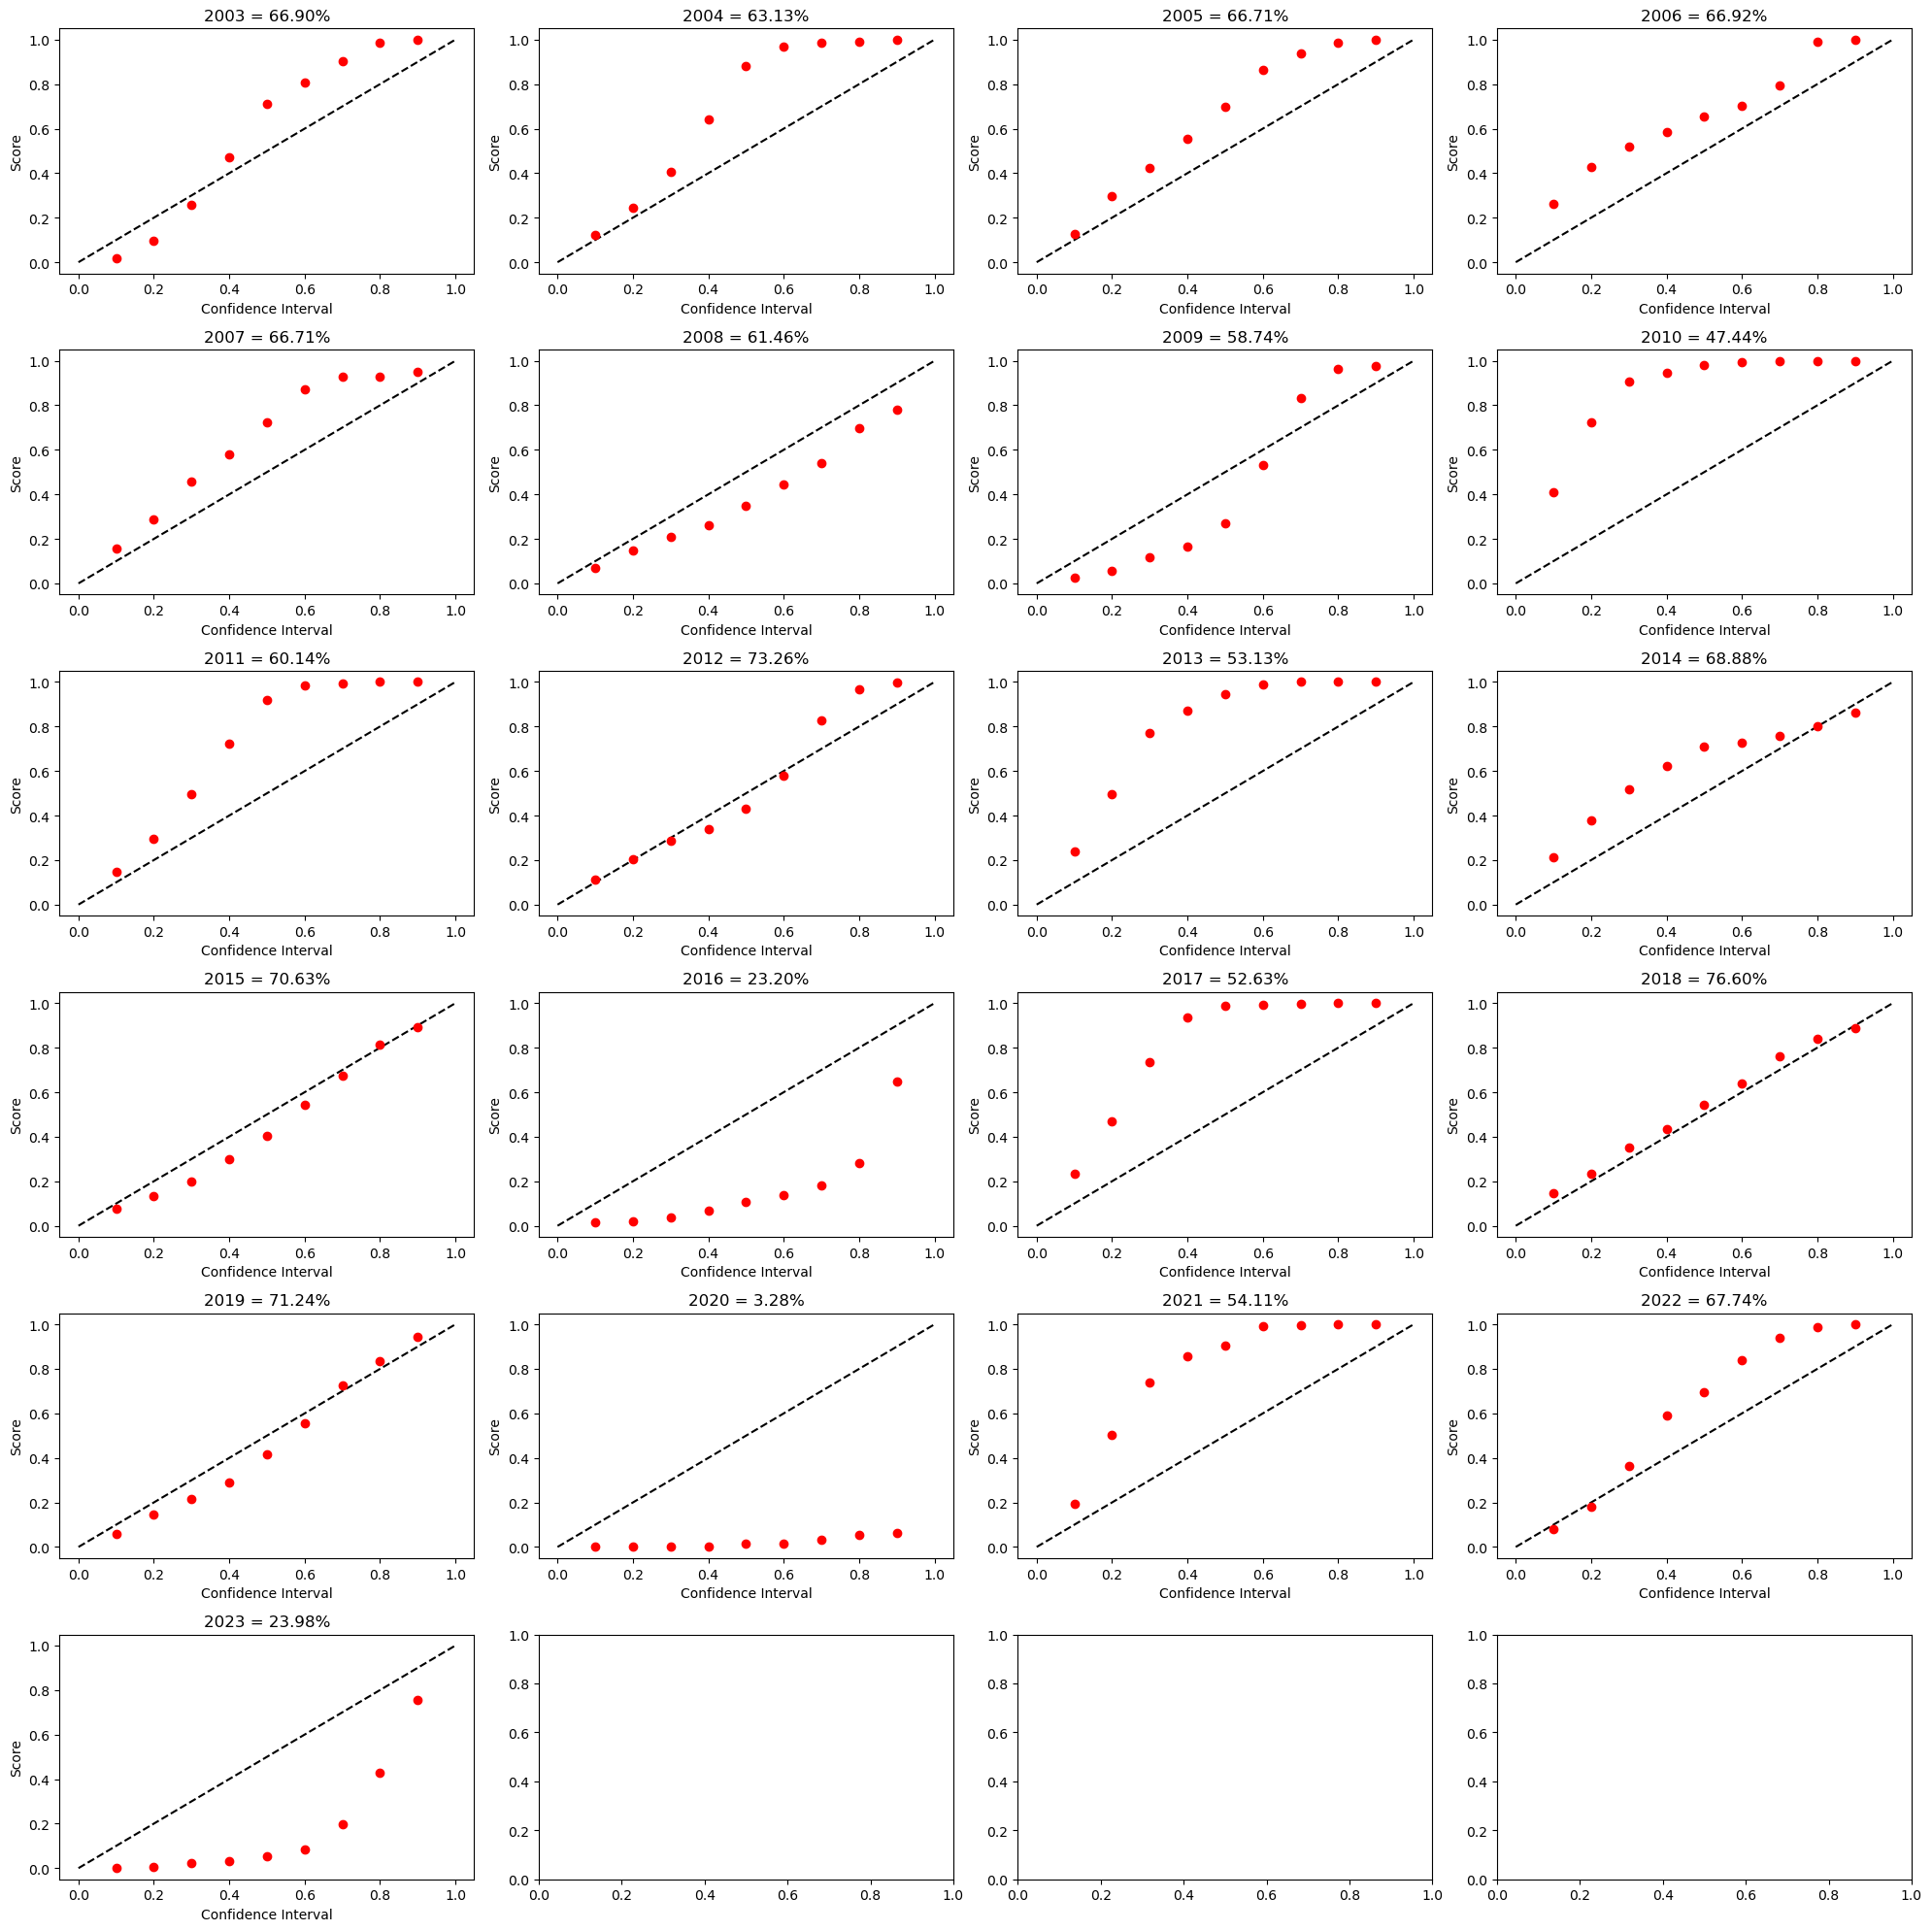

In [137]:
fig, axs = plt.subplots(nrows=len(years)//4, ncols=4, figsize=(20, 20))
for i, y in enumerate(years[window_size_years+1:]):
    ax = axs[i//4, i%4]
    ax.plot((0,1), (0,1), 'k--')
    ax.plot(np.array(confidence_intervals) / 100, ci_scores.loc[y], 'ro')
    ax.set(title=f'{y} = {scores[i]:,.2%}', xlabel='Confidence Interval', ylabel='Score')
plt.tight_layout(); plt.show()
    